## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin","miami" ,"pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    elif split=="test":
        f_in = ROOT_PATH + "test" + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        outputs = pickle.load(open(ROOT_PATH + 'train' + "/" + city + "_outputs", "rb")) #this isnt actually used
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [150]:
for i in range(1,len(cities)):
    train_dataset2=ArgoverseDataset(city = cities[i], split = split)
    train_dataset=train_dataset+train_dataset2

In [3]:
#city = 'austin' 
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [6]:
for i in range(1,len(cities)):
    val_dataset2=ArgoverseDataset(city = cities[i], split = split)
    val_dataset=val_dataset+val_dataset2

In [4]:
len(val_dataset)

2399

## Create a DataLoader class for training

In [5]:
batch_sz = 4  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz,shuffle=False)

In [6]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        #print(x.shape)
        x = x.reshape(-1, 60, 2)
        #print(x.shape)
        return x

In [7]:
class Regression(torch.nn.Module):
 
    def __init__(self):
        super(Regression, self).__init__()
        self.linear = torch.nn.Linear(100, 120)
 
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.linear(x)
        #print(x.shape)
        x = x.reshape(-1,60,2)
        #print(x.shape)
        return x

In [37]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        #self.drop= nn.Dropout(p=0.2)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, hn = self.rnn(x.float(), h0.detach())
        #out=self.drop(out)
        #print(out.shape)
        out = self.fc(out[:, -1, :])
        #print(out.shape)
        out = out.reshape(-1,60,2)
        #print(out.shape)
        return out

In [9]:
import torch.nn.functional as F

class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        
        #self.drop= nn.Dropout(p=0.2)

        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x,hidden):
        #h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        #x = x.transpose(0, 1)#.transpose(0, 1).to(device)
        #print(x.shape)
        x=x.float()
        #out= self.fc(x)
        out, hidden = self.lstm(x, hidden)
        #out, hn = self.lstm(x.float(), h0.detach())
        #out=self.drop(out)
        print(out.shape)
        out = F.relu(out)#.to(device)
        out = self.fc(out[:,-1,:])
        #print(out.shape)
        out = out.reshape(-1,60,2)
        #print(out.shape)
        return out

In [63]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:0')
input_size = 2
hidden_size = 28#256
output_size = 120
batch_size = 4
n_layers = 2
seq_len = 50
#epochs = 11

In [64]:
model = RNNModel(input_size, hidden_size, n_layers, output_size)
#criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
#pred = Regression()
#opt = optim.Adam(pred.parameters(), lr=1e-4)
def fitData(x, y, transform="MinMax"):
    if transform == 'MinMax':
        scaler = MinMaxScaler()
    elif transform == "Standard":
        scaler = StandardScaler()
    else:
        return x, y

    scaler.fit(x.reshape(-1, 2))
    scaler.fit(y.reshape(-1, 2))
    x_ = scaler.transform(x.reshape(-1, 2)).reshape(-1, 50, 2)
    y_ = scaler.transform(y.reshape(-1, 2)).reshape(-1, 60, 2)

    return x_, y_, scaler

In [66]:
class min_max(object):
    def __call__(self, tensor):
        t_max=tensor.max(dim=1, keepdim=True)[0]
        t_min=tensor.min(dim=1, keepdim=True)[0]
        scale = 1.0 / (t_max - t_min) 
        tensor.mul_(scale).sub_(t_min)
        return tensor,t_max,t_min,scale

In [67]:
import matplotlib.pyplot as plt
epochs=[]
losses=[]
for epoch in range(100):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        scaler=min_max()
        #print(inp.shape)
        #inp_scale,t_max,t_min,scale=scaler(inp)
        #t_min=t_min.to(device)
        #scale=scale.to(device)
        #print(inp_scale.shape)
        #inp_scale=inp_scale.reshape(-1,50,2)
        preds = model(inp)
        #print(preds)
        #print(t_min)
        #print(preds.shape)
        #print(out.shape)
        #print(t_min.shape)
        #preds=preds.add_(t_min).div_(scale)
        loss = ((preds - out) ** 2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epochs.append(epoch)
    losses.append(total_loss / len(train_dataset))
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
plt.plot(epochs,losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#adam,.001,relu,batch=4, 73000

epoch 0 loss: 8810093.327367103
epoch 1 loss: 366095.5533322186


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

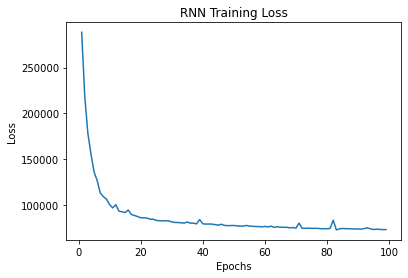

In [657]:
plt.plot(epochs[1:],losses[1:])
plt.title("RNN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [656]:
val_loader = DataLoader(val_dataset,batch_size=batch_sz,shuffle=True)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    #inp, out, scaler = fitData(inp, out, 'MinMax')
    #inp=torch.from_numpy(inp)
    #out=torch.from_numpy(out)
    preds = model(inp)
    
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('loss: {}'.format(val_loss / len(val_dataset)))

loss: 72688.15391001369


In [ ]:
enumerate(val_loader)

In [40]:
test_dataset = ArgoverseDataset(city = "palo-alto", split = 'test')
test_loader = DataLoader(test_dataset,batch_size=batch_sz,shuffle=True)

In [41]:
len(test_dataset)

1686

In [42]:
test_loader

## Sample a batch of data and visualize 

In [ ]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    print(inp.shape, out.shape)
    break
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cuda:0')
input_size = 2
hidden_size = 256
output_size = 60
batch_size = 4
n_layers = 2
seq_len = 50
epochs = 11

In [48]:
import torch.nn.functional as F
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.MaxPool1d(4)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.MaxPool1d(5)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.shape[0]
        

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs).to(device)
        p = self.p1(c).to(device)
        c = self.c2(p).to(device)
        p = self.p2(c).to(device)
        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1).to(device)
        
        p = F.relu(p)#.to(device)
        output, hidden = self.lstm(p, hidden)
        conv_seq_len = output.shape[0]
        output = output.view(conv_seq_len * batch_size, self.hidden_size).to(device) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
#         output = torch.tanh(self.out(output))
        output = self.out(output).to(device)
        output = output.view( -1, self.output_size, conv_seq_len).to(device)
        return output, hidden

In [49]:
rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers).to(device)
optimizer = optim.Adam(rnn.parameters(), lr = 0.01)
lossFunction = nn.MSELoss().to(torch.float32)